In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from scipy.spatial import Delaunay, Voronoi, voronoi_plot_2d
from halton_points import HaltonPoints
from function_Fm import *
from explicit_RK import *

from scipy.sparse import csc_matrix
from scipy.sparse.linalg import gmres

## Boundary

In [2]:
nf = (2**0+1)**2
r = HaltonPoints(2, nf).haltonPoints()
fxl = r.copy()
fxl[:, 0] = 0
fxr = r.copy()
fxr[:, 0] = 1
fyu = r.copy()
fyu[:, 1] = 0
fyd = r.copy()
fyd[:, 1] = 1
Mb = np.vstack((fxl, fxr, fyu, fyd))

boundary_points = pd.DataFrame(Mb, columns=['x', 'y'])
boundary_points['Collocation'] = 'Boundary'

## Interior

In [3]:
poly_b = np.array([[-1, -1, 1], [1/2, 3/2, -1], [3/2, 1/8, -3/8]])
npnts = (2**1+1)**2

uh = solve_matrix(Mb=Mb, npnts=npnts, poly_b=poly_b, rbf='TPS')
X0 = uh.X_0()

interior_points = pd.DataFrame(uh.Mi, columns=['x', 'y'])
interior_points['Collocation'] = 'Interior'

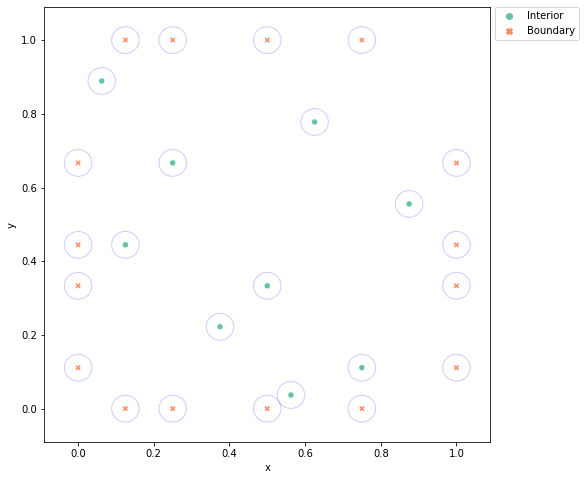

In [4]:
points = pd.concat([interior_points, boundary_points])

stable = stabillity(Mb, npnts)
qx = stable.qX()

fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x='x', y='y', data=points, hue='Collocation',
                style='Collocation', palette='Set2')
for hk in points[['x', 'y']].values:
    c = plt.Circle(hk, qx, fill=False, alpha=0.2, color='b')
    ax.add_patch(c)

plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.);

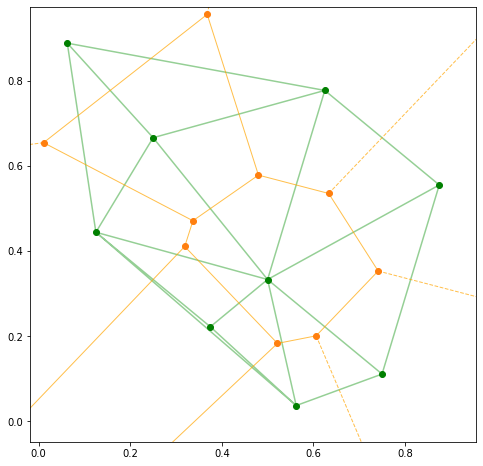

In [5]:
tri = Delaunay(uh.Mi)
vor = Voronoi(uh.Mi)

fig, axs = plt.subplots(figsize=(8, 8))
g = voronoi_plot_2d(vor, ax=axs, line_colors='orange', line_alpha=0.7)
plt.triplot(uh.Mi[:, 0], uh.Mi[:, 1], tri.simplices, alpha=0.5)
plt.plot(uh.Mi[:, 0], uh.Mi[:, 1], 'o', color='g')
plt.show()


In [6]:
print("Interior points: {:,.0f} \nBoundary points: {:,.0f} \nTotal points: {:,.0f}".format(uh.Mi.shape[0], uh.Mb.shape[0], uh.Mi.shape[0] + uh.Mb.shape[0]))

Interior points: 9 
Boundary points: 16 
Total points: 25


In [7]:
#uh.epsilon = 5.956
cond = np.linalg.cond(uh.ACaps())
det = np.linalg.det(uh.ACaps())
print('Condition number: {:,.0f} \nDeterminant: {:,.9f}'.format(cond, det))

Condition number: 9 
Determinant: -79,470.449290552


## Solve Matrix RK-Newthon

In [8]:
Y = np.vstack((X0, X0))
dt = 0.01
uh.variables(X0, dt, Y)
#rr = uh.Rk(0.02)

In [9]:
np.linalg.norm(Y, 'fro')

1.4424150856223872

In [13]:
for _ in range(50):
    A, b = uh.inexact_Newthon(0.01)
    Sp = np.linalg.inv(A).dot(b)
    Y =  Y - Sp
    uh.Y = Y
    print(np.linalg.norm(Y, 'fro'))

1.4182464012332048
1.422300021068256
1.4236076028321667
1.4245934905463569
1.4253345823305914
1.4258471640166286
1.426179518752456
1.4263932561832258
1.426532846764971
1.4266238235332307
1.4266816245740865
1.4267172576489242
1.4267389008595737
1.4267521930395048
1.4267606511549797
1.426766296131254
1.4267702324393576
1.4267730561710543
1.4267751008063152
1.4267765713793883
1.4267776112465798
1.4267783312265578
1.4267788200612606
1.426779147550189
1.4267793661632107
1.4267795132491896
1.4267796139986308
1.4267796846254976
1.4267797352292513
1.4267797720382338
1.4267797989766058
1.4267798186504659
1.4267798329101036
1.4267798431427348
1.4267798504158773
1.4267798555499775
1.4267798591636698
1.4267798617108898
1.4267798635154922
1.426779864803094
1.4267798657284432
1.4267798663971756
1.4267798668818945
1.4267798672333132
1.426779867487585
1.4267798676709675
1.426779867802762
1.4267798678972083
1.4267798679647776
1.4267798680131067


In [15]:
uh.Y

array([[0.23528245, 0.15695918],
       [0.11396527, 0.31232393],
       [0.34703772, 0.04637848],
       [0.06070636, 0.21133565],
       [0.2696763 , 0.34170223],
       [0.17787744, 0.11357588],
       [0.37899496, 0.23924612],
       [0.0280848 , 0.40219054],
       [0.26785149, 0.01354271],
       [0.22968458, 0.14743934],
       [0.10722815, 0.30934602],
       [0.34625482, 0.03097459],
       [0.05723916, 0.20053266],
       [0.25804073, 0.3429449 ],
       [0.16816425, 0.11907412],
       [0.37880811, 0.23096499],
       [0.02473584, 0.40748493],
       [0.26192873, 0.00885021]])

In [ ]:
objects = np.array(tuple(uh.Fp(0)), dtype=object)
F = np.vstack(objects[:, 0])
w = np.hstack(objects[:,1])
Bsk = np.vstack(objects[:,2])
Bsk = np.vstack((Bsk[::2, :], Bsk[1::2, :]))
F[::2, :]

In [ ]:
F[1::2, :]

In [ ]:
t0, te = 0, 1
N = 100
X0 = uh.X_0()
exp_RK = explicit_RungeKutta(Fm, X0, t0, te, N, uh)

In [ ]:
exp_RK.solve()

In [ ]:
exp_RK.timegrid

In [ ]:
def plot_solution(M, Mi, i):
    n = int(M.shape[0]/Mi.shape[0])
    df_i = pd.DataFrame()
    for _ in range(n):
        df_i = pd.concat([df_i, pd.DataFrame(Mi, columns=['x', 'y'])])
    df_i = df_i.reset_index().rename(columns={'index': 'i'})
    df = pd.DataFrame(M, columns=['u', 'v', 't'])
    df = pd.concat([df_i, df], axis=1)
    dff = df.loc[df['i'] == i]
    plt.figure(figsize=(8, 8))
    sns.lineplot(x='t', y='v', data=dff)
    return df

def u(Mi, norm_x, t, alpha=1.):
    return Mi/((t+alpha) + (t+alpha)**2 * np.exp(norm_x**2/(4*(alpha +t))))

In [ ]:
norm_x = np.linalg.norm(uh.Mi, axis=1).reshape(-1,1)
ex = u(uh.Mi, norm_x, 0.10)
np.mean(abs(ex - exp_RK.solution[10])/ex)*100

In [ ]:
norm_x = np.linalg.norm(uh.Mi, axis=1).reshape(-1, 1)
n = exp_RK.solution.shape[0]
error = list()
for t in exp_RK.timegrid[1:]:
    ei = np.sqrt((np.linalg.norm(u(uh.Mi, norm_x, t)-exp_RK.solution[int(t*100)]))/n)
    error.append(ei)

In [ ]:
plt.plot(exp_RK.timegrid[1:], error)
plt.xlabel("$t$")
plt.ylabel("RMSE")

In [ ]:
sol_dict = {}
for ti in range(exp_RK.solution.shape[0]):
    sol_dict[str(ti/100)] = str(exp_RK.solution[ti])

In [ ]:
import json

with open("solution.json", 'w') as outf:
    json.dump(sol_dict, outf)

## Exact solution

In [ ]:
norm_x = np.linalg.norm(uh.Mi, axis=1).reshape(-1,1)
ni = uh.Mi.shape[0]
u0= u(uh.Mi, norm_x, 0.)
u0 = np.hstack((u0, np.array([0.]*ni).reshape(-1,1)))
for t in exp_RK.timegrid[1:]:
    ui= u(uh.Mi, norm_x, t)
    ui = np.hstack((ui, np.array([t]*ni).reshape(-1,1)))
    u0 = np.vstack((u0, ui))

exact_sol = plot_solution(u0, uh.Mi, 0)

In [ ]:
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(0, 1, 0.025)
Y = np.arange(0, 1, 0.025)
n_X = np.linalg.norm(np.hstack((X.reshape(-1,1), Y.reshape(-1,1))), axis=1).reshape(-1,1)
X, Y = np.meshgrid(X, Y)
t=0.05
V = Y/((1+t) + (1+t)*np.exp(n_X/(4*(1+t))))

# Plot the surface.
surf = ax.plot_surface(X, Y, V, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

In [ ]:
L, H = np.pi*np.mgrid[-1:1:1000j, -1:1:1000j]
T = np.cos(L)*np.cos(2*H)
H = np.cos(L) + H
fig, ax = plt.subplots()
surf = plt.contourf(L, H, T, cmap="hot")
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()


In [ ]:
L, H = np.pi*np.mgrid[-1:1:10j, -1:1:10j]
L

In [ ]:
ti = exact_sol.t.unique()[5]
sol_i = exact_sol[exact_sol['t'] == ti][['u', 'v']].values

In [ ]:
app_u_i = X0 + ti*Fm(X0, uh)
np.mean(abs(sol_i- app_u_i)[:,0])

## Solution

In [ ]:
sol = FDM_time(timegrid, X0, uh)
for t, s in sol.items():
    print('Time: {:,.4f}'.format(t))
    print(s, '\n')